<a href="https://www.kaggle.com/code/mohitsingh351/plant-disease-prediction?scriptVersionId=191822940" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        break
        

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report , auc , accuracy_score

import tensorflow as tf
from tensorflow import keras

from PIL import Image
import cv2
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense,Dropout,Conv2D, Flatten,MaxPooling2D
from keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory

import warnings
warnings.filterwarnings('ignore')

In [3]:
path = "/kaggle/input/plant-disease-recognition-dataset/Train/Train"
train = image_dataset_from_directory(path, batch_size=32,
                                    image_size=(256,256),shuffle=True)

Found 1322 files belonging to 3 classes.


In [4]:
path = "/kaggle/input/plant-disease-recognition-dataset/Test/Test"
test = image_dataset_from_directory(path, batch_size=32,
                                    image_size=(256,256),shuffle=True)

Found 150 files belonging to 3 classes.


In [5]:
path = "/kaggle/input/plant-disease-recognition-dataset/Validation/Validation"
valid = image_dataset_from_directory(path, batch_size=32,
                                    image_size=(256,256),shuffle=True)

Found 60 files belonging to 3 classes.


In [6]:
class_labels = train.class_names
class_labels

['Healthy', 'Powdery', 'Rust']

In [7]:
print(len(train))
print(len(test))
print(len(valid))

42
5
2


## Data Preprocessing

In [8]:
for image_batch,image_label in train.take(1):
    print(image_batch[0])
    print(class_labels[image_label[0].numpy()])

tf.Tensor(
[[[106.77539  157.77539   88.77539 ]
  [108.       159.        90.      ]
  [103.375    156.375     84.375   ]
  ...
  [180.5625   189.5625   110.5625  ]
  [212.59375  218.59375  144.59375 ]
  [164.36133  164.36133  113.17383 ]]

 [[108.62305  159.62305   93.4668  ]
  [110.072266 160.67773   92.15625 ]
  [103.62891  156.47266   84.47266 ]
  ...
  [199.15625  207.84375  128.82422 ]
  [167.98242  171.41992  114.64844 ]
  [ 76.90625   83.21875   35.375   ]]

 [[108.375    159.375     92.375   ]
  [110.46875  156.46875   91.46875 ]
  [105.       157.        85.      ]
  ...
  [211.57227  216.3125   152.63477 ]
  [ 99.75     104.75      64.75    ]
  [ 76.22266   83.22266   39.222656]]

 ...

 [[ 95.34375  127.9375    80.9375  ]
  [103.       135.        85.      ]
  [102.666016 135.66602   80.666016]
  ...
  [ 87.5957   125.00195   43.783203]
  [ 93.16211  131.16211   48.16211 ]
  [ 96.8457   129.8457    48.845703]]

 [[109.03906  135.19531   90.19531 ]
  [110.146484 140.60547   

## Train Image Data

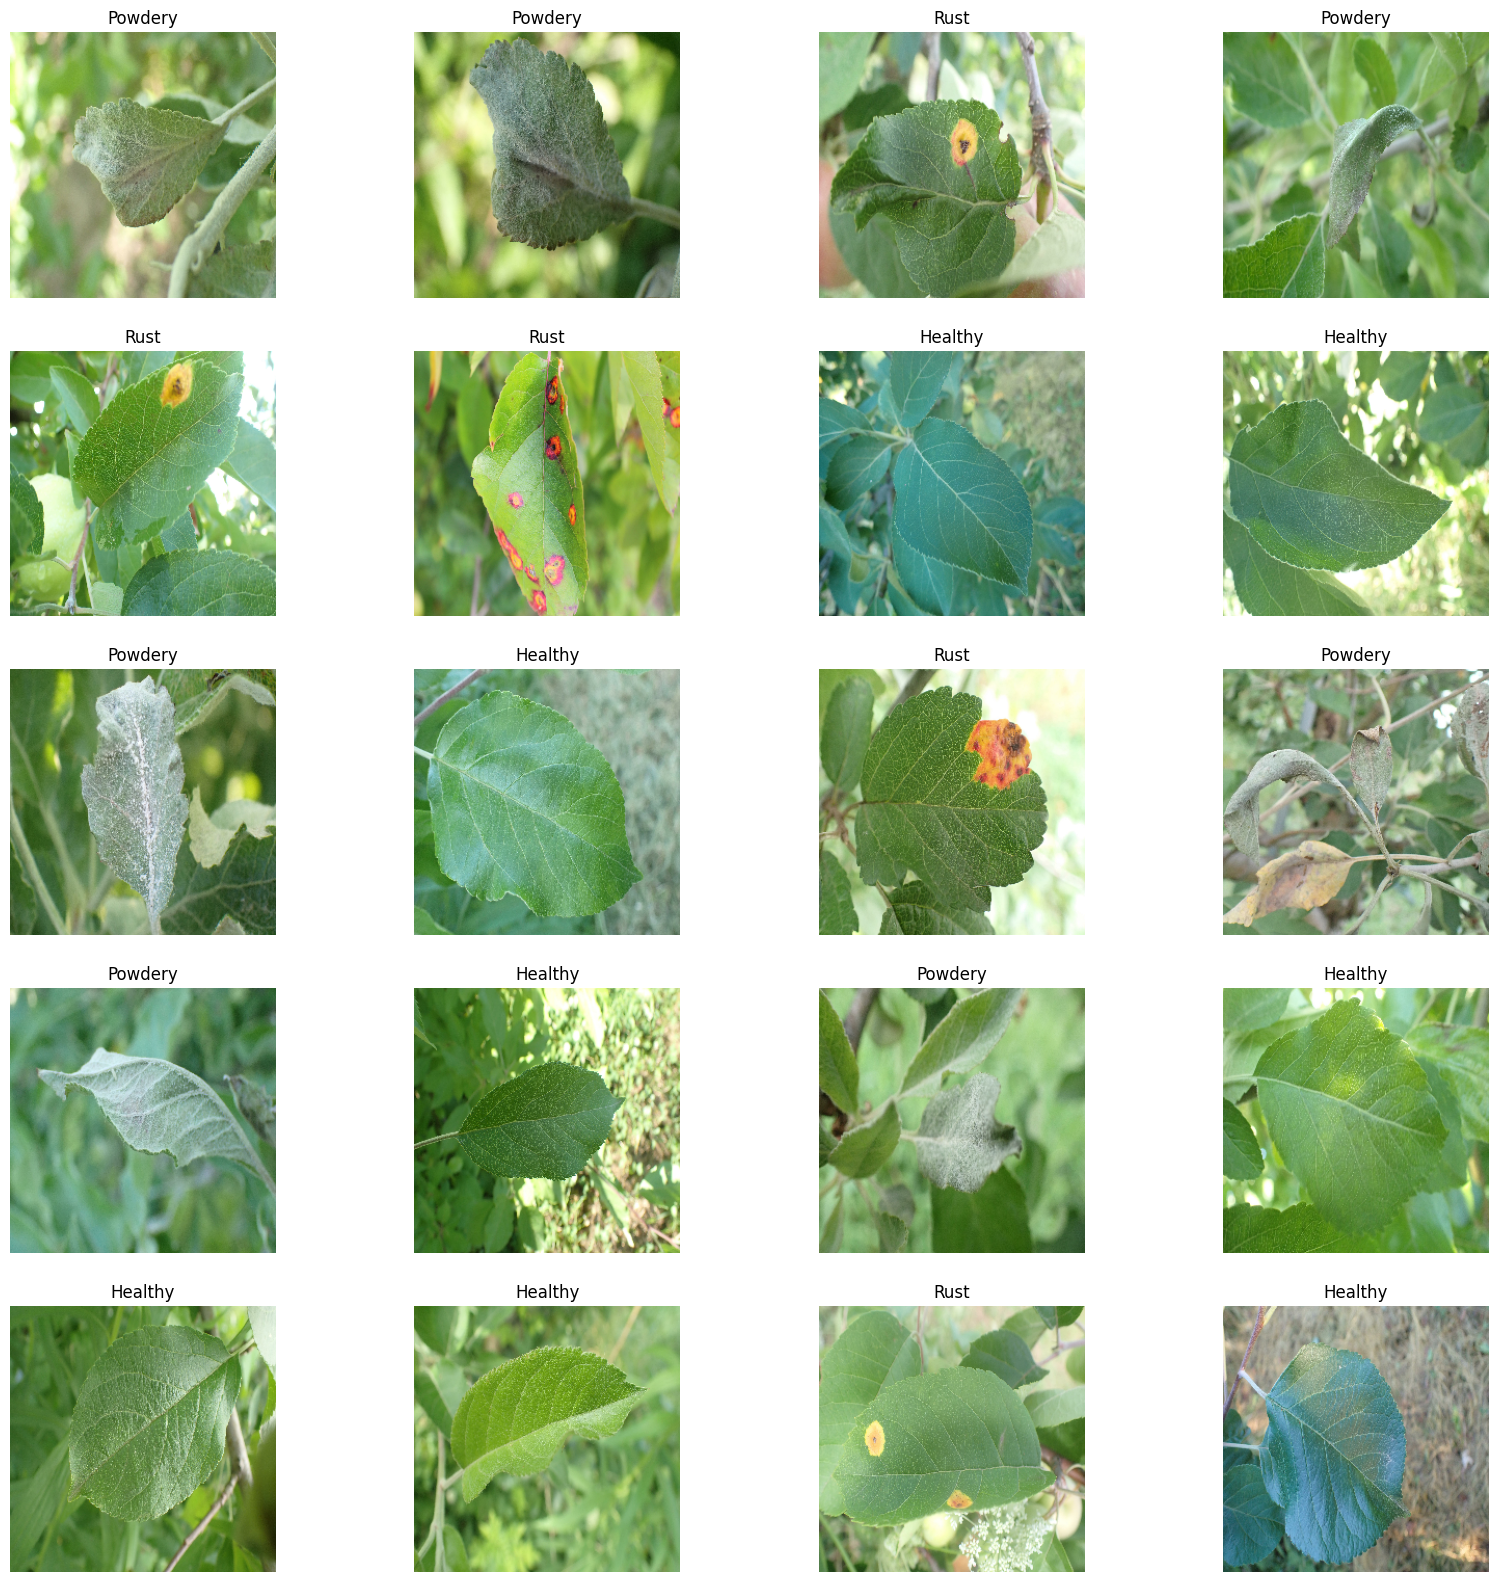

In [9]:
plt.figure(figsize=(20,20))
for image_batch , image_label in train.take(1):
    for i in range(20):
        plt.subplot(5,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_labels[image_label[i].numpy()])
        plt.axis("off")

## Resizing and Rescaling Images

In [10]:
resizing_and_rescaling = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(256,256),
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255)
])

## Data Augmentation

In [11]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.3),
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.3),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

## Creat CNN Model 

In [12]:
IMAGE_SIZE=256
CHANNELS=3
BATCH_SIZE=32
EPOCHS=10

input_shape=(BATCH_SIZE , IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

model= tf.keras.models.Sequential([
  resizing_and_rescaling,
  data_augmentation,
  # Convolution layer 1
  tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1),padding='valid',activation='relu',input_shape=input_shape),
  tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
  # Convolution layer 2
  tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3),strides=(1,1),padding='valid',activation='relu'),
  tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
  # Convolution layer 3  
  tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3),strides=(1,1),padding='valid',activation='relu'),
  tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
  # Convolution layer 4  
  tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3),strides=(1,1),padding='valid',activation='relu'),
  tf.keras.layers.MaxPool2D(pool_size=(2,2)),

  # Flatten Layers
  tf.keras.layers.Flatten(),

  # Dense layers
  tf.keras.layers.Dense(units=500,activation='relu'),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(units=500,activation='relu'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(units=100,activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(units=3,activation='softmax')

])

model.build(input_shape=input_shape)

In [13]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [ ]:
model.compile(optimizer="adam",
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

history = model.fit(train ,  batch_size=32 ,epochs=10,
                verbose=1,
                validation_data=valid) # epochs=10

Epoch 1/10
24/42 [================>.............] - ETA: 1:23 - loss: 1.0942 - accuracy: 0.3841

## Accuracy and loss on Train and Test

In [ ]:
loss,acc = model.evaluate(train)
print("Loss on Train data:",loss)
print("Accuracy on Train data:",acc)

loss1,acc1 = model.evaluate(test)

print("Loss on Test data:",loss1)
print("Accuracy on Test data:",acc1)

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

In [ ]:
EPOCHS=1
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc, label="Training Accuracy")
plt.plot(range(EPOCHS),val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

#plt.figure(figsize=(6,6))
plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss, label="Training Loss")
plt.plot(range(EPOCHS),val_loss, label="Validation Loss")
plt.legend(loc="lower right")
plt.title("Training and Validation Loss")
plt.show()

## Image Predictions on Test Data

In [ ]:
def Prediction(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array((images[i].numpy()))
    img_array = tf.expand_dims(img_array,0)     # create a batch

    predictions = model.predict(img_array)

    predicted_class = class_labels[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    
    return predicted_class , confidence

In [ ]:
plt.figure(figsize=(20,25))
for images , labels in test.take(1):
    for i in range(20):
        ax = plt.subplot(5,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        #plt.title(class_labels[labels[i]])


        predicted_class , confidence = Prediction(model,images[i].numpy())
        actual_class = class_labels[labels[i]]
        plt.title(f"Actual:{actual_class}\n Predicted:{predicted_class}\n Confidence:{confidence}%")
        plt.axis("off")

In [ ]:
from tensorflow.keras.models import load_model

# Assuming 'model' is your trained Keras model
# model.save('model.h5')